# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [3]:
# standard libraries
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

# Setting up connection
from sqlalchemy import create_engine

# we will print the logs into a file outside
import logging

# NLP functions
import nltk
# if first time installing nltk: nltk.download()
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

# modelling sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix


# Make sure we can see all columns in our dataframes
pd.set_option('display.max_columns', 50)

In [17]:
## IF NEEDED:
nltk.download()
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('corpora')

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


Exception in thread Thread-5:
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.2288.0_x64__qbz5n2kfra8p0\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\jsbin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nltk\downloader.py", line 2104, in run
    for msg in self.data_server.incr_download(self.items):
  File "C:\Users\jsbin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nltk\downloader.py", line 624, in incr_download
    yield from self._download_list(info_or_id, download_dir, force)
  File "C:\Users\jsbin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nltk\downloader.py", line 667, in _download_list
    for msg in self.incr_download(item, download_dir, force):

True

In [14]:
def setup_logger(logger_name, log_file, level=logging.INFO):
    l = logging.getLogger(logger_name)
    formatter = logging.Formatter('%(message)s') # %(asctime)s - %(levelname)s - 
    fileHandler = logging.FileHandler(log_file, mode='w')
    fileHandler.setFormatter(formatter)
    streamHandler = logging.StreamHandler()
    streamHandler.setFormatter(formatter)

    l.setLevel(level)
    l.addHandler(fileHandler)
    l.addHandler(streamHandler) 

def close_logger(logger):
    """Close all handlers on logger object."""
    if logger is None:
        return
    for handler in list(logger.handlers):
        handler.close()
        logger.removeHandler(handler)    

In [5]:
# load data from database
engine = create_engine('sqlite:///../data/disaster_response.db')
df = pd.read_sql('SELECT * FROM messages_with_categories', engine)

# let's keep only the original message
# The data needs to be 1 dimensional for countvectorizer and tfidftransformer
X = df['message']
# Get all values that we are trying to predict
y = df.drop(columns=['id', 'message', 'original', 'genre'], axis=1)

Text(0.5, 1.0, 'Proportion of 1s in each category')

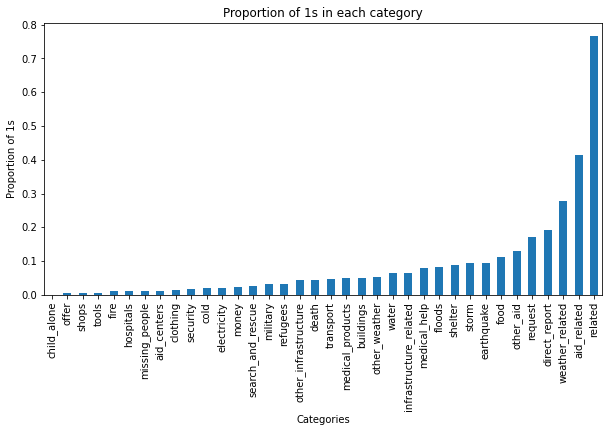

In [6]:
fig, ax = plt.subplots(figsize = (10,5))
y.mean(axis = 0).sort_values().plot(kind = 'bar')
ax.set_xlabel("Categories")
ax.set_ylabel("Proportion of 1s")
ax.set_title("Proportion of 1s in each category")

In [7]:
# remove child_alone as it contains only 1 value
y.drop(columns=['child_alone'], axis=1, inplace=True)

### 2. Write a tokenization function to process your text data

In [ ]:
def tokenize(text):
    # First remove punctation and lowercase all letters
    text = re.sub(
        r"[^a-zA-Z0-9]", 
        " ", 
        text.lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    

    # lemmatize 
    lemmatizer = WordNetLemmatizer()
    
    # clean the tokens
    clean_tokens = []
    for token in tokens:
        clean_token = lemmatizer.lemmatize(token).lower().strip()
        clean_tokens.append(clean_token)
    return clean_tokens

In [15]:
for message in X[:4]:
    tokens = tokenize(message)
    print(message)
    print(tokens, '\n')

LookupError: 
**********************************************************************
  Resource [93momw-1.4[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('omw-1.4')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/omw-1.4[0m

  Searched in:
    - 'C:\\Users\\jsbin/nltk_data'
    - 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.10_3.10.2288.0_x64__qbz5n2kfra8p0\\nltk_data'
    - 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.10_3.10.2288.0_x64__qbz5n2kfra8p0\\share\\nltk_data'
    - 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.10_3.10.2288.0_x64__qbz5n2kfra8p0\\lib\\nltk_data'
    - 'C:\\Users\\jsbin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [91]:
first_pipeline = Pipeline([
        (
            'vect', 
            CountVectorizer(
                tokenizer = tokenize,
                max_df=0.75)),
        (
            'tfidf', 
            TfidfTransformer(
                sublinear_tf = False)),
        (
            'clf', 
            MultiOutputClassifier(
                RandomForestClassifier(
                    n_estimators = 500,
                    min_samples_leaf = 1)))
    ])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [93]:
def fit_predict(X_train,X_test,y_train,a_pipeline):
    print("We train")
    a_pipeline.fit(X_train, y_train)

    # predict on test data
    print("We predict")
    y_pred = a_pipeline.predict(X_test)

    return a_pipeline, y_pred

In [94]:
%%time
first_pipeline, y_pred_first = fit_predict(X_train,X_test,y_train,first_pipeline)

	 we train
	 we predict
CPU times: total: 1h 16min 19s
Wall time: 1h 47min 26s


### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [96]:
def results_pipeline(predictions, name_pipeline):
    setup_logger('log_pipeline', f'logs/{name_pipeline}_log.txt')
    logger = logging.getLogger('log_pipeline')

    for idx, column in enumerate(y_test.columns):
        logger.info('feature predicted: ' + column)
        logger.info('-'*53)
        logger.info(classification_report(y_test[column], predictions[:,idx], zero_division = 0))
        logger.info("\n")
    close_logger(logger)

In [97]:
%%time
results_pipeline(y_pred_first, name_pipeline = "first_pipeline")

feature predicted: related
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.27      0.40      1487
           1       0.82      0.97      0.89      5058

    accuracy                           0.81      6545
   macro avg       0.77      0.62      0.64      6545
weighted avg       0.80      0.81      0.78      6545



feature predicted: request
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      5445
           1       0.88      0.44      0.59      1100

    accuracy                           0.90      6545
   macro avg       0.89      0.71      0.76      6545
weighted avg       0.89      0.90      0.88      6545



feature predicted: offer
-----------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   

CPU times: total: 1.64 s
Wall time: 1.64 s


### 6. Improve your model
Use grid search to find better parameters. 

In [99]:
parameters = {
    'vect__max_df': [0.5, 0.75, 1], # started with 0.75
    'tfidf__sublinear_tf': [True, False], # started with False
    'clf__estimator__n_estimators' : [10, 100, 500], # started with 500
    'clf__estimator__min_samples_leaf': [1, 2, 5] # started with 1
}    
# Volgende keer n_jobs=6, cv=5, verbose=2
gs_cv = GridSearchCV(
    first_pipeline,
    param_grid=parameters
    )


In [100]:
# fit the grid search
gs_cv.fit(X_train, y_train)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [95]:
gs_cv.best_estimator_.steps

NameError: name 'gs_cv' is not defined

In [ ]:
%%time
results_pipeline(gs_cv.predict(X_test), name_pipeline = "gridsearch_pipeline")

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [ ]:
class TextLengthExtractor(BaseEstimator, TransformerMixin):
    """
    Customized class to add the length of text as a feature.
    This class is used in building model
    """

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        X_length = pd.Series(X).apply(lambda x: len(x))
        return pd.DataFrame(X_length)

In [ ]:
second_pipeline = Pipeline([
        (
            'features', 
            FeatureUnion([
                ('text_pipeline', Pipeline([
                    (
                        'vect', 
                        CountVectorizer(
                            tokenizer = tokenize,
                            max_df=0.75)),
                    ('tfidf', TfidfTransformer(sublinear_tf = False)) ])),
                ('text_length', TextLengthExtractor()) ]
            )),
        (
            'clf', 
            MultiOutputClassifier(
                RandomForestClassifier(
                    n_estimators = 500,
                    min_samples_leaf = 1)))
    ])
second_pipeline, second_y_pred = fit_predict(X_train,X_test,y_train,second_pipeline)

In [ ]:
results_pipeline(multinb_y_pred, name_pipeline = "second_pipeline")

### 9. Export your model as a pickle file

In [ ]:
preferred_pipeline = first_pipeline
pipeline.to_pickle("../models/pipeline.pickle")

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.